In [72]:
import numpy as np
# Define a mars-rover environment, where we have 10 states and 2 actions (left and right).
class MarsRover:
    def __init__(self, n_states=10, n_actions=2):
        self.n_states = n_states
        self.n_actions = n_actions
        self.state = 0

    def reset(self):
        self.state = 0
    
    def step(self, action):
        if action == 0:
            self.state = max(0, self.state - 1)
        else:
            self.state = min(self.n_states - 1, self.state + 1)
        if self.state == 0 and action == 0:
            reward = 10
        # if self.state == self.n_states/2:
        #     reward = -250
        else:
            if self.state == self.n_states - 1 and action == 1:
                reward = 250
            else:
                reward = -1
        return self.state, reward


In [73]:


class UCBmixLCB:
    def __init__(self, n_states, n_actions, ini_Q, c=2, gamma=0.9):
        """
        n_states: Number of states
        n_actions: Number of actions
        c: UCB/LCB exploration coefficient
        gamma: Discount factor
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.c = c
        self.gamma = gamma
        
        # Counters and estimates
        self.nsa = np.zeros((n_states, n_actions))                # Visits for (s,a)
        self.nsas = np.zeros((n_states, n_actions, n_states))     # Transition counts for (s,a,s')
        self.R = np.zeros((n_states, n_actions))                  # Running average rewards for (s,a)
        
        # Q-values
        self.Q = np.ones((n_states, n_actions)) * 10          # Optimistic initialization
        self.pQ = np.ones((n_states, n_actions)) * ini_Q
        self.oQ = np.ones((n_states, n_actions)) * ini_Q
        self.N = np.zeros((n_states, n_actions))                  # For action-selection bonus
        self.t = 0                                                # Global counter
        self.lr = 0.1                                             # Learning Rate


    def ucb_select_action(self, state):
        """
        Selects the action using UCB:
          Q(s,a) + c * sqrt(t / (N(s,a) + 1e-5))
        """
        self.t += 1
        bonus = self.c * np.sqrt(self.t / (self.N[state, :] + 1e-5))
        ucb_values = self.Q[state, :] + bonus
        return np.argmax(ucb_values)
    
    def lcb_select_action(self, state):
        """
        Selects the action using LCB:
          Q(s,a) - c * sqrt(1 / (N(s,a) + 1e-5))
        """
        self.t += 1
        bonus = self.c * np.sqrt(self.t / (self.N[state, :] + 1e-5))
        lcb_values = self.Q[state, :] - bonus
        return np.argmax(lcb_values)
    
    def greedy_select_action(self, state, default = 'greedy'):
        """
        Selects the action that has the highest Q(s,a).
        """
        if default == 'greedy':
            return np.random.choice(np.flatnonzero(self.Q[state] == self.Q[state].max()))
        elif default == 'ucb':
            return np.random.choice(np.flatnonzero(self.oQ[state] == self.oQ[state].max()))
        elif default == 'lcb':
            return np.random.choice(np.flatnonzero(self.pQ[state] == self.pQ[state].max()))
    
    def epsilon_greedy_select_action(self, state, epsilon=0.1):
        """
        Epsilon-greedy action selection:
          - With probability epsilon, pick a random action.
          - Otherwise, pick the action that maximizes Q(s,a).
        """
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.Q[state])

    def update(self, state, action, reward, next_state):
        """
        Update the empirical model, running average reward, and Q-value immediately
        after observing transition (state, action, reward, next_state).
        """
        # Update counts.
        self.nsa[state, action] += 1
        self.nsas[state, action, next_state] += 1
        self.N[state, action] += 1
        
        # Update running average reward for (state, action).
        self.R[state, action] += (reward - self.R[state, action]) / self.nsa[state, action]
        
        # Compute empirical transition probabilities for (state, action).
        p_hat = self.nsas[state, action, :] / (self.nsa[state, action] + 1e-5)
        
        # Immediate Q-value update using the empirical model:
        # Q(s,a) = R(s,a) + gamma * sum_{s'} [P_hat(s'|s,a) * max_{a'} Q(s',a')]
        if self.N[state, action] > 1:
            self.Q[state, action] = (1 - self.lr) * self.Q[state, action] + self.lr * ( reward + \
            self.gamma * np.dot(p_hat, np.max(self.Q, axis=1)))
        else: 
            self.Q[state, action] = reward + self.gamma * np.dot(p_hat, np.max(self.Q, axis=1))
        

    def update_mix(self, state, action, reward, next_state):
        """
        Update the empirical model, running average reward, and Q-value immediately
        after observing transition (state, action, reward, next_state).
        """
        # Update counts.
        self.nsa[state, action] += 1
        self.nsas[state, action, next_state] += 1
        self.N[state, action] += 1
        
        # Update running average reward for (state, action).
        self.R[state, action] += (reward - self.R[state, action]) / self.nsa[state, action]
        
        # Compute empirical transition probabilities for (state, action).
        p_hat = self.nsas[state, action, :] / (self.nsa[state, action] + 1e-5)
        
        # Immediate Q-value update using the empirical model:
        # Q(s,a) = R(s,a) + gamma * sum_{s'} [P_hat(s'|s,a) * max_{a'} Q(s',a')]
        if self.N[state, action] > 1:
            self.oQ[state, action] = (1 - self.lr) * self.oQ[state, action] + self.lr * ( reward + \
                self.gamma * np.dot(p_hat, np.max(self.oQ, axis=1)) + self.c * np.sqrt(1 / (self.N[state,action] + 1e-5)))
            self.pQ[state, action] = (1 - self.lr) * self.pQ[state, action] + self.lr * ( reward + \
                self.gamma * np.dot(p_hat, np.max(self.pQ, axis=1)) - self.c * np.sqrt(1 / (self.N[state,action] + 1e-5))) 
        else:
            self.oQ[state, action] = reward + self.gamma * np.dot(p_hat, np.max(self.oQ, axis=1)) + self.c * np.sqrt(1 / (self.N[state,action] + 1e-5))
            self.pQ[state, action] = reward + self.gamma * np.dot(p_hat, np.max(self.pQ, axis=1)) - self.c * np.sqrt(1 / (self.N[state,action] + 1e-5))

In [74]:
# Experiment settings.
n_states = 10
n_actions = 2
c = 100
horizon = 5000  # Maximum number of steps per experiment.
n_experiments = 20
opt_weight = 0.5  # For mix strategy: probability to use UCB vs. LCB.

# Arrays to store cumulative reward per step for each experiment.
# Each has shape (n_experiments, horizon)
mix_cum_rewards = np.zeros((n_experiments, horizon))
ucb_cum_rewards = np.zeros((n_experiments, horizon))
greedy_cum_rewards = np.zeros((n_experiments, horizon))

In [85]:


for exp in range(n_experiments):
    # Initialize agents (each variant).
    mixagent = UCBmixLCB(n_states, n_actions, 10**3, c, gamma=0.9)
    ucbagent = UCBmixLCB(n_states, n_actions, 10**3, c, gamma=0.9)
    greedyagent = UCBmixLCB(n_states, n_actions, 10, c, gamma=0.9)
    
    # Initialize environments (assume MarsRover is defined with reset and step).
    env = MarsRover(n_states, n_actions)
    env1 = MarsRover(n_states, n_actions)
    env2 = MarsRover(n_states, n_actions)
    
    env.reset()
    env1.reset()
    env2.reset()
    
    total_reward_mix = 0
    total_reward_ucb = 0
    total_reward_greedy = 0
    
    # Run for a fixed number of steps (horizon).
    for step in range(horizon):
        # Get current states.
        state = env.state
        state1 = env1.state
        state2 = env2.state

        # Mix strategy: With probability opt_weight use UCB, otherwise use LCB.
        # if np.random.rand() < opt_weight:
        #    mix_action = mixagent.ucb_select_action(state)
        #else:
        #    mix_action = mixagent.lcb_select_action(state)

        if np.random.rand() < opt_weight:
            mix_action = mixagent.greedy_select_action(state, 'ucb')
        else:
            mix_action = mixagent.greedy_select_action(state, 'lcb')
        
        # Pure UCB strategy.
        ucb_action = ucbagent.greedy_select_action(state1, 'ucb')
        
        # testing:
        
        
        # Epsilon-greedy strategy.
        greedy_action = greedyagent.epsilon_greedy_select_action(state2, epsilon=0.05)
        
        # Step in each environment.
        next_state, mix_reward = env.step(mix_action)
        next_state1, ucb_reward = env1.step(ucb_action)
        next_state2, greedy_reward = env2.step(greedy_action)

        # if state1 == 9 and np.sum(ucbagent.N[9,:]) == 0:
        #    print('ucb_chooose_action:', ucb_action, 'according to', ucbagent.oQ[9,:], 'observe_reward:', ucb_reward)

        # if state == 9 and np.sum(mixagent.N[9,:]) == 0:
        #    print('mix_chooose_action:', mix_action, 'according to', mixagent.oQ[9,:], 'observe_reward:', mix_reward)
        
        # Update agents immediately.
        mixagent.update_mix(state, mix_action, mix_reward, next_state)
        ucbagent.update_mix(state1, ucb_action, ucb_reward, next_state1)
        greedyagent.update(state2, greedy_action, greedy_reward, next_state2)

        # if state == 9 and np.sum(mixagent.N[9,:]) == 1:
        #    print('updated_Q', mixagent.oQ[9,:], mixagent.pQ[9,:])
        
        # Accumulate rewards.
        total_reward_mix += mix_reward
        total_reward_ucb += ucb_reward
        total_reward_greedy += greedy_reward
        
        # Record the cumulative reward at the current step.
        mix_cum_rewards[exp, step] = total_reward_mix
        ucb_cum_rewards[exp, step] = total_reward_ucb
        greedy_cum_rewards[exp, step] = total_reward_greedy
        
        # Update environment states.
        env.state = next_state
        env1.state = next_state1
        env2.state = next_state2

    print('ucbagent_Q', ucbagent.oQ[9,:])  
    print(f"Experiment {exp+1}")
    print("Mix Strategy Total Reward:", total_reward_mix)
    print("UCB Strategy Total Reward:", total_reward_ucb)
    print("Epsilon-Greedy Strategy Total Reward:", total_reward_greedy)


ucbagent_Q [498.45080802 502.84960854]
Experiment 1
Mix Strategy Total Reward: 1240244
UCB Strategy Total Reward: 1238782
Epsilon-Greedy Strategy Total Reward: 48471
ucbagent_Q [498.45080802 502.84845225]
Experiment 2
Mix Strategy Total Reward: 1239513
UCB Strategy Total Reward: 1239742
Epsilon-Greedy Strategy Total Reward: 48746
ucbagent_Q [499.38312863 502.84643212]
Experiment 3
Mix Strategy Total Reward: 1240255
UCB Strategy Total Reward: 1240517
Epsilon-Greedy Strategy Total Reward: 48570
ucbagent_Q [496.99920721 502.84729737]
Experiment 4
Mix Strategy Total Reward: 1239251
UCB Strategy Total Reward: 1240746
Epsilon-Greedy Strategy Total Reward: 48548
ucbagent_Q [500.47954675 502.84441629]
Experiment 5
Mix Strategy Total Reward: 1242252
UCB Strategy Total Reward: 1242252
Epsilon-Greedy Strategy Total Reward: 48625
ucbagent_Q [500.47954675 502.84614389]
Experiment 6
Mix Strategy Total Reward: 1240244
UCB Strategy Total Reward: 1240757
Epsilon-Greedy Strategy Total Reward: 48372
ucba

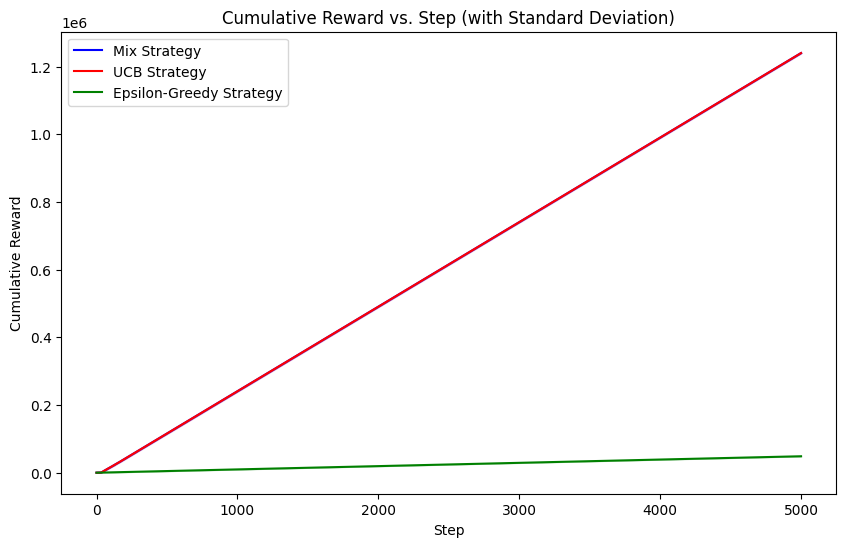

In [86]:
import matplotlib.pyplot as plt

avg_mix = np.mean(mix_cum_rewards, axis=0)
avg_ucb = np.mean(ucb_cum_rewards, axis=0)
avg_greedy = np.mean(greedy_cum_rewards, axis=0)

# Standard deviation at each step.
std_mix = np.std(mix_cum_rewards, axis=0)
std_ucb = np.std(ucb_cum_rewards, axis=0)
std_greedy = np.std(greedy_cum_rewards, axis=0)

steps = np.arange(horizon)

plt.figure(figsize=(10, 6))

# Plot for mix strategy.
plt.plot(steps, avg_mix, label="Mix Strategy", color='blue')
plt.fill_between(steps, avg_mix - std_mix, avg_mix + std_mix, color='blue', alpha=0.2)

# Plot for UCB strategy.
plt.plot(steps, avg_ucb, label="UCB Strategy", color='red')
plt.fill_between(steps, avg_ucb - std_ucb, avg_ucb + std_ucb, color='red', alpha=0.2)

# Plot for Epsilon-Greedy (Greedy) strategy.
plt.plot(steps, avg_greedy, label="Epsilon-Greedy Strategy", color='green')
plt.fill_between(steps, avg_greedy - std_greedy, avg_greedy + std_greedy, color='green', alpha=0.2)

plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward vs. Step (with Standard Deviation)")
plt.legend()
plt.show()

In [87]:
print('ucb_pessimism:', ucbagent.pQ)
print('mix_pessimism:', mixagent.pQ)


ucb_pessimism: [[383.42457241 375.80840035]
 [383.02103192 371.87457516]
 [103.99620006 348.76333308]
 [370.5185357  348.76333308]
 [370.5185357  401.92464991]
 [398.99550005 401.92464991]
 [ 98.49625506 401.92464991]
 [ 98.49625506 384.42451241]
 [ 98.49625506 530.47361892]
 [309.46655758 497.15154572]]
mix_pessimism: [[383.42457241 375.80840035]
 [383.02103192 401.92464991]
 [103.99620006 371.87457516]
 [ 98.49625506 401.92464991]
 [398.99550005 371.87457516]
 [ 98.49625506 348.76333308]
 [370.5185357  371.87457516]
 [398.99550005 384.42451241]
 [398.99550005 537.85295456]
 [312.79250806 497.15212334]]


In [88]:
print(ucbagent.N[9,:])
print(mixagent.N[9,:])

[   9. 4949.]
[   9. 4951.]


In [89]:
print('ucb_optimism:', ucbagent.oQ)
print('mix_optimism:', mixagent.oQ)

ucb_optimism: [[587.56567269 572.08238341]
 [586.86924368 576.01567544]
 [403.99370009 554.03722613]
 [574.86673995 554.03722613]
 [574.86673995 596.06585018]
 [598.99450005 596.06585018]
 [398.49375509 596.06585018]
 [398.49375509 588.56561269]
 [398.49375509 682.3193759 ]
 [496.99920721 502.84845225]]
mix_optimism: [[587.56567269 572.08238341]
 [586.86924368 596.06585018]
 [403.99370009 576.01567544]
 [398.49375509 596.06585018]
 [598.99450005 576.01567544]
 [398.49375509 554.03722613]
 [574.86673995 576.01567544]
 [598.99450005 588.56561269]
 [598.99450005 685.53549681]
 [498.37777599 502.84787463]]
